# For spline (two-model) method training only

### Import necessary packages and self-defined classes

In [2]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
# Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# random
import random
# math
import math
import scipy.interpolate
# self-defined model
from model_pic import *
from model_cal import *
from model_one import *
import pandas as pd

#PictureNet
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split

### Augamented dataset loading and preprocessing

In [3]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.9, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

### Load data for PhysicsNet

In [26]:
data_matrix_augmentation = pd.read_csv("Data_uniform/Data_aug/Spline_coef_aug.csv", header= None)
print(data_matrix_augmentation)

# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self,dataInput):
        x = dataInput.iloc[0:,3:].values
        y = dataInput.iloc[0:,0:2].values
        # x = np.random.normal(x,0.01)
        y0 = dataInput.iloc[:,0].values
        y1 = dataInput.iloc[:,1].values
        
        # Plot surface tension histogram
        n, bins, patches = plt.hist(x=y0, bins='auto', color='#0504aa',
                                    alpha=0.7, rwidth=0.85)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Surface Tension[mN/m]')
        plt.ylabel('Frequency')
        plt.title('Occurence of data per Surface Tension')\

        # Plot volume histogram
        # n, bins, patches = plt.hist(x=y1, bins='auto', color='#0504aa',
        #                             alpha=0.7, rwidth=0.85)
        # plt.grid(axis='y', alpha=0.75)
        # plt.xlabel('Volume[mm^3]')
        # plt.ylabel('Frequency')
        # plt.title('Occurence of data per Volume')

        self.x_train = torch.tensor(x,dtype=torch.float32)
        print(self.x_train.shape)
        self.y_train = torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        

          0         1          2         3         4         5         6   \
0       15.1   5.10061  14.150364  1.343070  0.560755 -0.204328 -0.058190   
1       15.1   5.10061  14.150364 -0.161344  0.560755 -0.204328 -0.058190   
2       15.1   5.10061  14.150364  0.442829  0.560755 -0.204328 -0.058190   
3       15.1   5.10061  14.150364  1.403207  0.560755 -0.204328 -0.058190   
4       15.1   5.20122  13.846032  0.061767  0.560057 -0.206831 -0.056986   
...      ...       ...        ...       ...       ...       ...       ...   
109539  93.2  44.81438  42.599241  1.326978  0.438854 -0.652535  0.146285   
109540  93.2  45.39140  43.012347  1.657659  0.451419 -0.664851  0.125092   
109541  93.2  45.39140  43.012347  1.722307  0.451419 -0.664851  0.125092   
109542  93.2  45.39140  43.012347  0.943215  0.451419 -0.664851  0.125092   
109543  93.2  45.39140  43.012347  1.005774  0.451419 -0.664851  0.125092   

              7         8         9   ...        15        16        17  \


torch.Size([109544, 22])


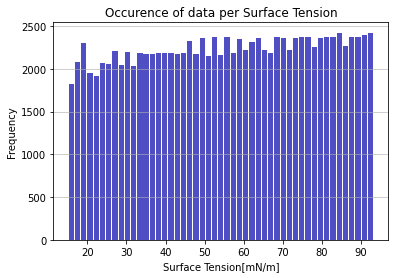

In [27]:
my_data_set_augmentation = Droplet_data_set(data_matrix_augmentation)
split_augmentation = DataSplit(my_data_set_augmentation, shuffle=True)  # Split the single dataset into 3 datasets for training, test and validation.
train_loader_augmentation, val_loader_augmentation, test_loader_augmentation = split_augmentation.get_split(batch_size=512, num_workers=0)

### Load data for PictureNet
Read image from files

In [6]:
train_img = []
data_matrix_augmentation = pd.read_csv("Data_uniform/Data_aug/Spline_coef_aug.csv", header= None)
data_image_augmentation = data_matrix_augmentation

for img_name in data_image_augmentation.iloc[0:,3:].index:      # modify the number depends on size of dataset
    # defining the image path
    image_path = 'Data_uniform/Data_aug/' + str(img_name) + '.png'      # modify the path depends on which dataset
    # reading the image
    img = imread(image_path, as_gray=True)
    img = img[4:-4, 4:-4]  #crop 
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    if img_name % 1000 == 0:
        print("Now loading pic: ", img_name)
    img = np.array(img)
    # appending the image into the list
    train_img.append(img)

Now loading pic:  0
Now loading pic:  1000
Now loading pic:  2000
Now loading pic:  3000
Now loading pic:  4000
Now loading pic:  5000
Now loading pic:  6000
Now loading pic:  7000
Now loading pic:  8000
Now loading pic:  9000
Now loading pic:  10000
Now loading pic:  11000
Now loading pic:  12000
Now loading pic:  13000
Now loading pic:  14000
Now loading pic:  15000
Now loading pic:  16000
Now loading pic:  17000
Now loading pic:  18000
Now loading pic:  19000
Now loading pic:  20000
Now loading pic:  21000
Now loading pic:  22000
Now loading pic:  23000
Now loading pic:  24000
Now loading pic:  25000
Now loading pic:  26000
Now loading pic:  27000
Now loading pic:  28000
Now loading pic:  29000
Now loading pic:  30000
Now loading pic:  31000
Now loading pic:  32000
Now loading pic:  33000
Now loading pic:  34000
Now loading pic:  35000
Now loading pic:  36000
Now loading pic:  37000
Now loading pic:  38000
Now loading pic:  39000
Now loading pic:  40000
Now loading pic:  41000
Now l

In [7]:
print("Total pic num =", len(train_img))

Total pic num = 109544


Plot a single image for viewing

Current image = 70716
Picture size = (82, 77)


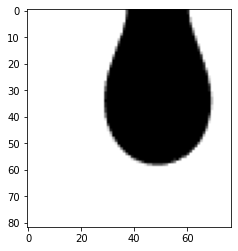

In [8]:
rand = random.randint(1, len(train_img))
print("Current image =", rand)
print("Picture size =", train_img[rand].shape)
plt.imshow(train_img[rand], cmap='gray')

Define the function

In [9]:
# Split and transfer the data from list to torch format
def split_n_transfer(x, y):
    # Points data split
    train_x_pic, rem_x_pic, train_y_pic, rem_y_pic = train_test_split(x, y, test_size = 0.2)    # default shuffle = True
    val_x_pic, test_x_pic, val_y_pic, test_y_pic = train_test_split(rem_x_pic, rem_y_pic, test_size = 0.5)

    # converting the train images of points and targets into torch format
    train_x_pic = train_x_pic.reshape(len(train_x_pic), 1, 82, 77)
    train_x_pic = torch.from_numpy(train_x_pic)
    train_y_pic = torch.from_numpy(train_y_pic)

    # converting the val images and target points into torch format
    val_x_pic = val_x_pic.reshape(len(val_x_pic), 1, 82, 77)
    val_x_pic = torch.from_numpy(val_x_pic)
    val_y_pic = torch.from_numpy(val_y_pic)
    # print(val_x_pic.shape, val_y_pic.shape)

    # converting the test images and targets into torch format for points
    test_x_pic = test_x_pic.reshape(len(test_x_pic), 1, 82, 77)
    test_x_pic  = torch.from_numpy(test_x_pic)
    test_y_pic = torch.from_numpy(test_y_pic)
    # print(test_x_pic.shape, test_y_pic.shape)
    
    return train_x_pic, train_y_pic, val_x_pic, val_y_pic, test_x_pic, test_y_pic

# converting the dataset into mini-batch dataset (input 4D -> 5D and 2D -> 3D)
def batch_transform(dataset, batch_size=512):
    batch = []
    batch_num = math.ceil(len(dataset)/batch_size)
    for i in range(batch_num):
        if len(dataset) == 4:
            if i < batch_num-1:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :, :, :])
            else:
                batch.append(dataset[i*batch_size:, :, :, :])
        else:
            if i < batch_num-1:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :])
            else:
                batch.append(dataset[i*batch_size:, :])
    return batch

# converting all raw datasets into batch datasets in the same time
def batch_all(train_x, train_y, val_x, val_y, test_x, test_y):
    train_x_pic = batch_transform(train_x)
    train_y_pic = batch_transform(train_y)
    val_x_pic = batch_transform(val_x)
    val_y_pic = batch_transform(val_y)
    test_x_pic = batch_transform(test_x)
    test_y_pic = batch_transform(test_y)
    return train_x_pic, train_y_pic, val_x_pic, val_y_pic, test_x_pic, test_y_pic

Create and splite the dataset for edge point model

In [10]:
# converting the list to numpy array
train_x_pic = np.array(train_img)
train_y_pic_augmentation = data_image_augmentation.iloc[0:,3:].values

train_x_pic_augmentation, train_y_pic_augmentation, val_x_pic_augmentation, val_y_pic_augmentation, test_x_pic_augmentation, test_y_pic_augmentation = \
    split_n_transfer(train_x_pic, train_y_pic_augmentation)

train_x_pic_augmentation, train_y_pic_augmentation, val_x_pic_augmentation, val_y_pic_augmentation, test_x_pic_augmentation, test_y_pic_augmentation = \
    batch_all(train_x_pic_augmentation, train_y_pic_augmentation, val_x_pic_augmentation, val_y_pic_augmentation, test_x_pic_augmentation, test_y_pic_augmentation)
    
print(len(train_x_pic_augmentation), len(train_y_pic_augmentation), len(val_x_pic_augmentation), \
    len(val_y_pic_augmentation), len(test_x_pic_augmentation), len(test_y_pic_augmentation))


172 172 22 22 22 22


### Deside to apply host or device


In [11]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)


cuda


## Define the functions for models

In [12]:
def loss_cal_phiysics(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def loss_cal_picture(loss_list, model, x_dataset, y_dataset):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t in range(len(x_dataset)):
            x = x_dataset[t]
            y = y_dataset[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score

def model_selection(model, path, loss, epoch_current, epoch_ref, loss_ref):
    loss_best = loss_ref
    epoch_best = epoch_ref
    if epoch_current == 0 and ~(os.path.isdir(path)):
            loss_current = loss[epoch_current]
            loss_best = loss[epoch_current]
            torch.save(model, path)
    else:
        loss_current = loss[epoch_current]
        if loss_current <= (loss_best * 1.1):   # 10% margin to get better fitting but a bit more loss
            loss_best = loss_current
            epoch_best = epoch_current
            torch.save(model, path)
    return loss_best, epoch_best

def train_physics(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0
    
    train_loader = train_loader_augmentation
    val_loader = val_loader_augmentation
    PATH_CAL = os.path.join(os.getcwd(), "model_cal_augmentation.pt")

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_phiysics(loss_train, model, train_loader)
        loss_cal_phiysics(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))

        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_CAL, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

def train_picture(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0

    train_x_pic = train_x_pic_augmentation
    train_y_pic = train_y_pic_augmentation
    val_x_pic = val_x_pic_augmentation
    val_y_pic = val_y_pic_augmentation
    PATH_PIC = os.path.join(os.getcwd(), "model_pic_augmentation.pt")

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(len(train_x_pic)):
            model.train()  # put model to training mode
            x = train_x_pic[t]
            y = train_y_pic[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_picture(loss_train, model, train_x_pic, train_y_pic)
        loss_cal_picture(loss_val, model, val_x_pic, val_y_pic)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
        
        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_PIC, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())

    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()


## Train PictureNet for spline

epoch 1: train_loss = 0.0027, val_loss = 0.0028
epoch 2: train_loss = 0.0010, val_loss = 0.0011
epoch 3: train_loss = 0.0023, val_loss = 0.0024
epoch 4: train_loss = 0.0030, val_loss = 0.0032
epoch 5: train_loss = 0.0011, val_loss = 0.0012
epoch 6: train_loss = 0.0047, val_loss = 0.0049
epoch 7: train_loss = 0.0087, val_loss = 0.0091
epoch 8: train_loss = 0.0057, val_loss = 0.0059
epoch 9: train_loss = 0.0039, val_loss = 0.0040
epoch 10: train_loss = 0.0067, val_loss = 0.0071
epoch 11: train_loss = 0.0059, val_loss = 0.0061
epoch 12: train_loss = 0.0042, val_loss = 0.0044
epoch 13: train_loss = 0.0019, val_loss = 0.0020
epoch 14: train_loss = 0.0012, val_loss = 0.0013
epoch 15: train_loss = 0.0006, val_loss = 0.0007
epoch 16: train_loss = 0.0006, val_loss = 0.0007
epoch 17: train_loss = 0.0039, val_loss = 0.0041
epoch 18: train_loss = 0.0007, val_loss = 0.0007
epoch 19: train_loss = 0.0006, val_loss = 0.0006
epoch 20: train_loss = 0.0006, val_loss = 0.0006
epoch 21: train_loss = 0.0007

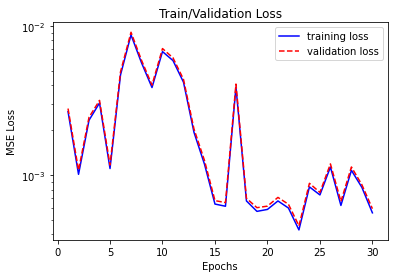

In [27]:
in_channel = 1
channel_1 = 16
channel_2 = 32
channel_3 = 64
node_1 = 1024
node_2 = 1024
out_channel = 22

learning_rate = 1e-3

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)
epoch = 30

train_picture(model_picture, optimizer, epoch)

### Retrain with SGD

epoch 1: train_loss = 0.0002, val_loss = 0.0003
epoch 2: train_loss = 0.0002, val_loss = 0.0003
epoch 3: train_loss = 0.0002, val_loss = 0.0003
epoch 4: train_loss = 0.0002, val_loss = 0.0003
epoch 5: train_loss = 0.0002, val_loss = 0.0003
epoch 6: train_loss = 0.0002, val_loss = 0.0003
epoch 7: train_loss = 0.0002, val_loss = 0.0003
epoch 8: train_loss = 0.0002, val_loss = 0.0003
epoch 9: train_loss = 0.0002, val_loss = 0.0003
epoch 10: train_loss = 0.0002, val_loss = 0.0003
epoch 11: train_loss = 0.0002, val_loss = 0.0003
epoch 12: train_loss = 0.0002, val_loss = 0.0003
epoch 13: train_loss = 0.0002, val_loss = 0.0003
epoch 14: train_loss = 0.0002, val_loss = 0.0003
epoch 15: train_loss = 0.0002, val_loss = 0.0003
epoch 16: train_loss = 0.0002, val_loss = 0.0003
epoch 17: train_loss = 0.0002, val_loss = 0.0003
epoch 18: train_loss = 0.0002, val_loss = 0.0003
epoch 19: train_loss = 0.0002, val_loss = 0.0003
epoch 20: train_loss = 0.0002, val_loss = 0.0003
The model is saved at epoch =

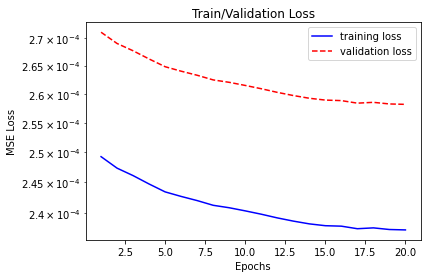

In [30]:
PATH_PIC = os.path.join(os.getcwd(), "model_pic_augmentation.pt")

model_picture_trained = torch.load(PATH_PIC)

learning_rate = 1e-4

optimizer = optim.SGD(model_picture_trained.parameters(), lr=learning_rate)
epoch = 20

train_picture(model_picture_trained, optimizer, epoch)

### Visualization of outcomes

Spline Model Interpolation points

In [13]:
#Number of interpolation points to use for PhysicsNet and plotting
Num_points = 80

# Load YC matrix for point values and s data for interpolation
data_s = pd.read_csv("Data_uniform/s.csv", header= None)

s = data_s.values
s = s.reshape(1,len(s))

# Interpolate to 160 points using a linear vector for s
ss = np.linspace(s[0][0],s[0][-1],Num_points)

data_YC = pd.read_csv("Data_uniform/YC.csv", header= None)
YC = torch.Tensor(data_YC.values)

print("shape of YC =", YC.shape)

shape of YC = torch.Size([40, 11])


Plot difference Spline and ground truth

In [14]:
PATH_PIC = os.path.join(os.getcwd(), "model_pic_augmentation.pt")

model_picture_trained = torch.load(PATH_PIC)


rand1 = random.randint(0, len(test_x_pic_augmentation)-1)
rand2 = random.randint(0, len(test_x_pic_augmentation[rand1])-1)

print("current testing batch =", rand1)
print("current testing image =", rand2)

score_pic_pred = prediction(model_picture_trained, test_x_pic_augmentation[rand1][rand2].reshape(1, 1, 82, 77))

print("shape of score_pic_pred[0, 0:11] =", score_pic_pred[0, 0:11].shape)

## Prediction 
# Multiply the found Chebyshev coefficients with YC matrix to obtain edge points
score_pic_r = torch.matmul(YC ,score_pic_pred[0, 0:11]) 
score_pic_z = torch.matmul(YC ,score_pic_pred[0, 11:22])

# Do polynominal fitting through data to get more data points
score_pic_r = np.polyval(np.polyfit(s[0],score_pic_r.numpy(),15), ss)
score_pic_z = np.polyval(np.polyfit(s[0],score_pic_z.numpy(),15), ss)

# Convert back to torch
score_pic_r = torch.tensor(score_pic_r)
score_pic_z = torch.tensor(score_pic_z)

## Ground Truth
# Multiply the found Chebyshev coefficients with YC matrix to obtain edge points
test_y_pic_r = torch.matmul(YC ,test_y_pic_augmentation[rand1][rand2][0:11].float()) 
test_y_pic_z = torch.matmul(YC ,test_y_pic_augmentation[rand1][rand2][11:22].float()) 

# Do polynominal fitting through data to get more data points
test_y_pic_r = np.polyval(np.polyfit(s[0],test_y_pic_r.numpy(),15), ss)
test_y_pic_z = np.polyval(np.polyfit(s[0],test_y_pic_z.numpy(),15), ss)

# Convert back to torch
test_y_pic_r = torch.tensor(test_y_pic_r)
test_y_pic_z = torch.tensor(test_y_pic_z)

# Print all points out for viewing
# for num in range(len(test_y_pic_r)):
#    print(num+1, ": Ground Truths =", test_y_pic_z[num].item(), ", Prediction =", score_pic_z[num].item())

print("shape of test_y_pic_r =", test_y_pic_r.shape)

current testing batch = 2
current testing image = 283
shape of score_pic_pred[0, 0:11] = torch.Size([11])
shape of test_y_pic_r = torch.Size([80])


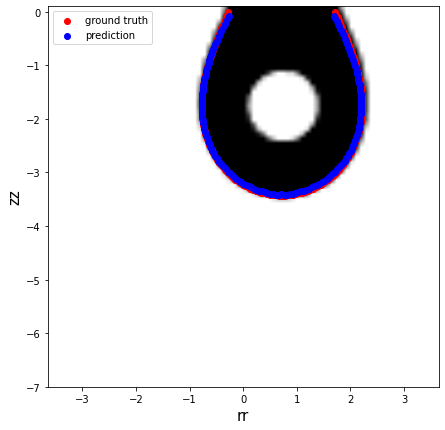

In [15]:
# scattering points for ground truth
gt_r_pos = test_y_pic_r
if gt_r_pos[-1] >= 0:
    gt_r_neg = -torch.flip(test_y_pic_r, [0]) + 2*gt_r_pos[0]
else:  
    gt_r_neg = -torch.flip(test_y_pic_r, [0]) - gt_r_pos[0]
gt_z_pos = test_y_pic_z
gt_z_neg = torch.flip(test_y_pic_z, [0])
gt_r = torch.cat((gt_r_neg, gt_r_pos))
gt_z = torch.cat((gt_z_neg, gt_z_pos))

# scattering points for prediction
pred_r_pos = score_pic_r
if pred_r_pos[-1] >= 0:
    pred_r_neg = -torch.flip(score_pic_r, [0]) + 2*pred_r_pos[0]
else:  
    pred_r_neg = -torch.flip(score_pic_r, [0]) - pred_r_pos[0]
pred_z_pos = score_pic_z
pred_z_neg = torch.flip(score_pic_z, [0])
pred_r = torch.cat((pred_r_neg, pred_r_pos))
pred_z = torch.cat((pred_z_neg, pred_z_pos))

# plotting
fig, ax = plt.subplots(1,1,figsize=(7, 7),facecolor=(1, 1, 1))
# a1 = fig.add_axes([0,0,1.5,1])
# a1.set_xlim(0,3)
# a1.set_title("Estimated drop edge versus ground truth", fontsize = 15)
ax.imshow(test_x_pic_augmentation[rand1][rand2][0],cmap='gray',aspect='auto', extent=(-3.5,3.5,-7,0.1), interpolation ='bilinear')
plt.scatter(gt_r, gt_z, c="red", label="ground truth")
plt.scatter(pred_r, pred_z, c="blue", label="prediction")

plt.xlabel("rr",fontsize = 15)
plt.ylabel("zz",fontsize = 15)
plt.legend()
plt.axis('equal')
plt.show()

## Train PhysicsNet for spline

epoch 1: train_loss = 1768.9754, val_loss = 1844.0981
epoch 2: train_loss = 1366.9331, val_loss = 1419.8453
epoch 3: train_loss = 1045.7162, val_loss = 1089.0650
epoch 4: train_loss = 574.7630, val_loss = 598.2738
epoch 5: train_loss = 374.3303, val_loss = 389.6936
epoch 6: train_loss = 259.5365, val_loss = 271.1472
epoch 7: train_loss = 100.3271, val_loss = 106.5467
epoch 8: train_loss = 54.3326, val_loss = 57.6794
epoch 9: train_loss = 18.3871, val_loss = 19.4066
epoch 10: train_loss = 6.2968, val_loss = 6.5931
epoch 11: train_loss = 3.5423, val_loss = 3.6780
epoch 12: train_loss = 2.7326, val_loss = 2.8291
epoch 13: train_loss = 1.8983, val_loss = 1.9574
epoch 14: train_loss = 1.1939, val_loss = 1.2265
epoch 15: train_loss = 1.3128, val_loss = 1.3714
epoch 16: train_loss = 2.4067, val_loss = 2.5205
epoch 17: train_loss = 0.8451, val_loss = 0.8840
epoch 18: train_loss = 0.9245, val_loss = 0.9624
epoch 19: train_loss = 1.8202, val_loss = 1.8785
epoch 20: train_loss = 0.6953, val_loss 

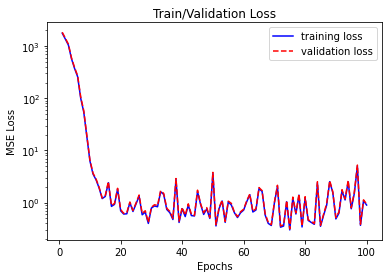

In [20]:
in_channel = 22
node_1 = 512
node_2 = 512
node_3 = 256
node_4 = 256
node_5 = 64
node_6 = 16
out_channel = 2

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, node_5, node_6, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 100

train_physics(model_physics, optimizer, epoch)

### Retrain with SGD

epoch 1: train_loss = 0.1763, val_loss = 0.1861
epoch 2: train_loss = 0.1507, val_loss = 0.1608
epoch 3: train_loss = 0.1431, val_loss = 0.1493
epoch 4: train_loss = 0.1616, val_loss = 0.1713
epoch 5: train_loss = 0.1544, val_loss = 0.1622
epoch 6: train_loss = 0.2194, val_loss = 0.2309
epoch 7: train_loss = 0.1740, val_loss = 0.1826
epoch 8: train_loss = 0.1951, val_loss = 0.2060
epoch 9: train_loss = 0.1591, val_loss = 0.1652
epoch 10: train_loss = 0.1483, val_loss = 0.1553
epoch 11: train_loss = 0.1807, val_loss = 0.1913
epoch 12: train_loss = 0.2795, val_loss = 0.2935
epoch 13: train_loss = 0.1677, val_loss = 0.1761
epoch 14: train_loss = 0.1858, val_loss = 0.1941
epoch 15: train_loss = 0.2316, val_loss = 0.2413
epoch 16: train_loss = 0.2208, val_loss = 0.2316
epoch 17: train_loss = 0.1592, val_loss = 0.1677
epoch 18: train_loss = 0.1368, val_loss = 0.1439
epoch 19: train_loss = 0.1462, val_loss = 0.1542
epoch 20: train_loss = 0.1571, val_loss = 0.1636
epoch 21: train_loss = 0.1307

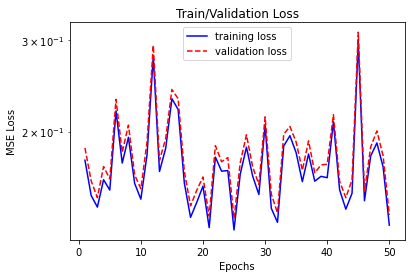

In [21]:
PATH_CAL = os.path.join(os.getcwd(), "model_cal_augmentation.pt")

model_physics_trained = torch.load(PATH_CAL)

learning_rate = 1e-4

optimizer = optim.SGD(model_physics_trained.parameters(), lr=learning_rate)
epoch = 50

train_physics(model_physics_trained, optimizer, epoch)

shape of x_test_augmentation = torch.Size([10955, 22])
Score of Augmented points prediction (two-model solution) = [0.7478776574134827, 0.8541305065155029, 0.9107257127761841, 0.9416704773902893, 0.9594705700874329, 0.9694203734397888, 0.9777270555496216, 0.9834778904914856, 0.9866727590560913, 0.989319920539856]


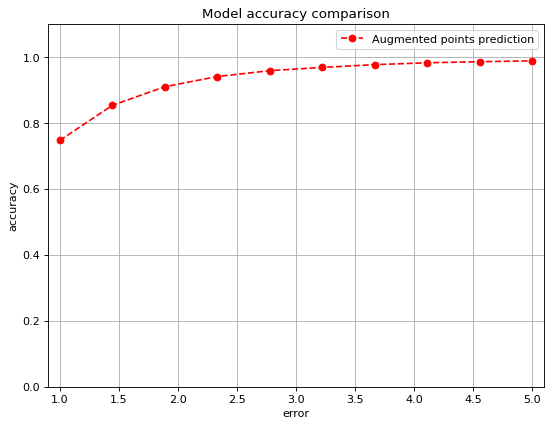

In [21]:
# load models
PATH_CAL = os.path.join(os.getcwd(), "model_cal_augmentation.pt")

model_physics_trained = torch.load(PATH_CAL, map_location='cpu')

# get all testing data in torch format
x_test_augmentation = split_augmentation.dataset.x_train[split_augmentation.test_sampler.indices]
y_test_augmentation = split_augmentation.dataset.y_train[split_augmentation.test_sampler.indices]

print("shape of x_test_augmentation =", x_test_augmentation.shape)

# predict
pred_test_augmentation = model_physics_trained(x_test_augmentation)

# set error margin to count as accurate
error_list = torch.linspace(0.01, 0.05, steps=10)

def score_cal(x, y, error):
    diff = ~abs((x-y)/y).gt(error) 
    count = diff[:, 0]
    return count.sum()/len(count)

score_list_augmentation = []
for i in range(len(error_list)):
    score_list_augmentation.append(score_cal(pred_test_augmentation, y_test_augmentation, error_list[i]).item())

print("Score of Augmented points prediction (two-model solution) =", score_list_augmentation) 
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(error_list*100 , score_list_augmentation, 'or--', label='Augmented points prediction')
plt.axis([0.9, 5.1, 0, 1.1])
plt.xlabel('error')
plt.ylabel('accuracy')
plt.title('Model accuracy comparison')
plt.grid()
plt.legend()

# Squential testing

## Reload dataset for the alignment

In [61]:
# converting the list to numpy array
train_x_test = np.array(train_img)
train_y_test = data_image_augmentation.iloc[0:,0:2].values

train_x_test, train_y_test, val_x_test, val_y_test, test_x_test, test_y_test = \
    split_n_transfer(train_x_test, train_y_test)

train_x_test, train_y_test, val_x_test, val_y_test, test_x_test, test_y_test = \
    batch_all(train_x_test, train_y_test, val_x_test, val_y_test, test_x_test, test_y_test)

print(len(train_x_test), len(train_y_test), len(val_x_test), len(val_y_test), len(test_x_test), len(test_y_test))

172 172 22 22 22 22


## Call PictureNet and get prediction for PhysicsNet

In [65]:
# load model
PATH_PIC = os.path.join(os.getcwd(), "model_pic_augmentation.pt")
model_picture_trained = torch.load(PATH_PIC, map_location='cpu')

# transfer from batches back into one
for i in range(len(test_x_test)):
    if i == 0:
        x_test = test_x_test[i]
        y_test = test_y_test[i]
        counter = True
    else:
        x_test = torch.cat([x_test, test_x_test[i]], dim=0)
        y_test = torch.cat([y_test, test_y_test[i]], dim=0)

# cropping bc not enough memory
x = x_test[0:100, :, :, :]
y = y_test[0:100, :]

# make prediction
test1 = model_picture_trained(x)
print(test1.shape)

torch.Size([100, 22])
tensor([[ 7.1262e-01,  5.5597e-01, -5.1170e-01,  ...,  1.3914e-03,
          3.7124e-03,  3.5944e-04],
        [ 4.3498e-01,  5.4894e-01, -5.2296e-01,  ...,  2.2177e-03,
          4.2562e-03, -1.1320e-03],
        [ 8.3004e-01,  5.4100e-01, -5.8945e-01,  ...,  4.5023e-03,
          2.4967e-03, -1.1116e-03],
        ...,
        [-7.8190e-02,  5.4496e-01, -2.5189e-01,  ..., -2.8271e-03,
          3.0743e-04,  4.3775e-03],
        [ 4.8444e-01,  5.4172e-01, -5.4876e-01,  ...,  4.4038e-03,
          2.0653e-03, -3.8731e-03],
        [-1.5540e-01,  5.5500e-01, -4.2133e-01,  ..., -1.3773e-03,
         -1.5484e-03, -2.4918e-03]], grad_fn=<AddmmBackward0>)


## Call PhysicsNet and get prediction for tension

In [67]:
# load model
PATH_CAL = os.path.join(os.getcwd(), "model_cal_augmentation.pt")
model_physics_trained = torch.load(PATH_CAL, map_location='cpu')

# make prediction
test2 = model_physics_trained(test1)
print(test2.shape)
print(test2[1:10])
print(y[1:10])

torch.Size([100, 2])
tensor([[63.3459, 22.5625],
        [76.0346, 28.2848],
        [55.2859, 20.8903],
        [45.8458, 16.4484],
        [52.2656, 18.6733],
        [80.3591, 28.7617],
        [43.8337, 18.1436],
        [26.1845,  7.4311],
        [48.8951, 18.3786]], grad_fn=<SliceBackward0>)
tensor([[80.2000, 23.4156],
        [81.4000, 30.2520],
        [55.2000, 21.5706],
        [48.2000, 17.1008],
        [51.8000, 19.2771],
        [87.3000, 29.3464],
        [41.2000, 17.9910],
        [24.4000,  7.2028],
        [47.2000, 18.6353]], dtype=torch.float64)


## Print results

Score of Augmented points prediction (two-model solution) = [0.12999999523162842, 0.3100000023841858, 0.4300000071525574, 0.5600000023841858, 0.6899999976158142, 0.7599999904632568, 0.800000011920929, 0.8199999928474426, 0.8799999952316284, 0.8999999761581421]


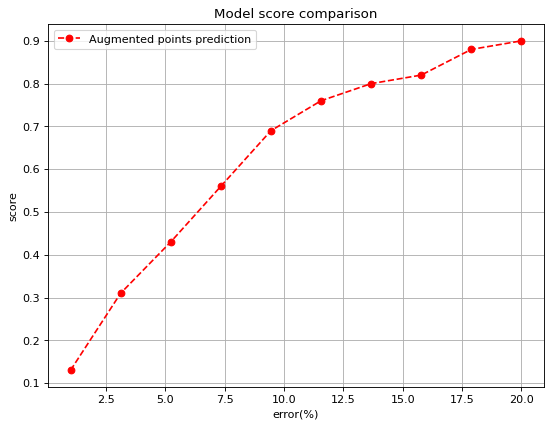

In [75]:
# set error margin to count as accurate
error_list = torch.linspace(0.01, 0.20, steps=10)

def score_cal(x, y, error):
    diff = ~abs((x-y)/y).gt(error) 
    count = diff[:, 0]
    return count.sum()/len(count)

score_list_test = []
for i in range(len(error_list)):
    score_list_test.append(score_cal(test2, y, error_list[i]).item())

print("Score of Augmented points prediction (two-model solution) =", score_list_test) 
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(error_list*100 , score_list_test, 'or--', label='Augmented points prediction')
plt.xlabel('error(%)')
plt.ylabel('score')
plt.title('Model score comparison')
plt.grid()
plt.legend()